In [1]:
import numpy as np
import os
from patchify import patchify  # Only to handle large images
from PIL import Image  # Use Pillow for image handling
from datasets import Dataset

In [2]:
# ------------------ Hyperparameters ------------------ #
image_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/images"  # Image directory path
mask_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/masks"    # Mask directory path

patch_size = 256          # Size of image patches
step = 256                # Step size for patchify
batch_size = 2            # Batch size for DataLoader
learning_rate = 1e-5      # Learning rate for optimizer
weight_decay = 0          # Weight decay for optimizer
num_epochs = 5           # Number of epochs for training
loss_fn_type = 'DiceCELoss'  # Loss function: Choose between DiceFocalLoss, FocalLoss, DiceCELoss
model_save_path = r"E:/Random Python Scripts/Tata HaxS/Models/Models/SAM/Lmao/lmao3.pth"  # Path to save model

# ------------------------------------------------------ #

In [3]:
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [4]:
all_img_patches = []
all_mask_patches = []

In [5]:
# Process images
for img_file in image_files:
    # Load each image using Pillow
    try:
        # Convert grayscale image to RGB
        large_image = Image.open(os.path.join(image_dir, img_file)).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {img_file} - {e}")
        continue
    
    # Convert the Pillow image to a NumPy array for patching
    large_image_np = np.array(large_image)
    
    # Patchify the large image (with 3 channels for RGB)
    patches_img = patchify(large_image_np, (patch_size, patch_size, 3), step=step)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
images = np.array(all_img_patches).squeeze(1)

In [6]:
# Process masks
for mask_file in mask_files:
    # Load each mask using Pillow
    try:
        large_mask = Image.open(os.path.join(mask_dir, mask_file)).convert('L')  # Load as grayscale
    except Exception as e:
        print(f"Error loading mask: {mask_file} - {e}")
        continue
    
    # Convert the Pillow mask to a NumPy array for patching
    large_mask_np = np.array(large_mask)

    # Patchify the large mask
    patches_mask = patchify(large_mask_np, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize mask values to [0, 1]
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

In [8]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

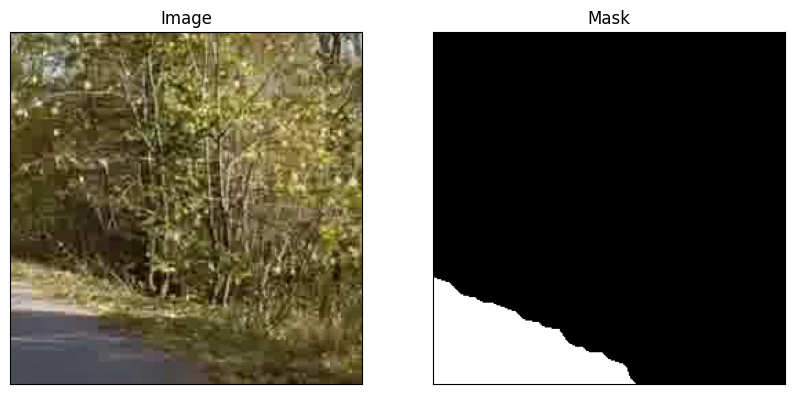

In [9]:
# Visualization
import matplotlib.pyplot as plt
import random

img_num = random.randint(0, filtered_images.shape[0] - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [10]:
# Get bounding boxes from mask
def get_bounding_box(ground_truth_map):
    # Get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [11]:
# Dataset class for SAM model
from torch.utils.data import Dataset
from transformers import SamProcessor

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert('RGB')  # Ensure the image is RGB
        ground_truth_mask = np.array(item["label"])

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [12]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [14]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [15]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [16]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Try DiceFocalLoss, FocalLoss, DiceCELoss based on the hyperparam
if loss_fn_type == 'DiceCELoss':
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
elif loss_fn_type == 'FocalLoss':
    seg_loss = monai.losses.FocalLoss(sigmoid=True)
elif loss_fn_type == 'DiceFocalLoss':
    seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True)

In [17]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:42<00:00,  1.19it/s]


EPOCH: 0
Mean loss: 0.07918573170562909


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:19<00:00,  1.26it/s]


EPOCH: 1
Mean loss: 0.0501468921556016


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:16<00:00,  1.26it/s]


EPOCH: 2
Mean loss: 0.04433743040367583


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:12<00:00,  1.28it/s]


EPOCH: 3
Mean loss: 0.04234287229643298


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:16<00:00,  1.27it/s]

EPOCH: 4
Mean loss: 0.03844951917046168


In [18]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), model_save_path)